# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
%matplotlib inline
from sklearn.utils import shuffle
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.core.display import clear_output
from tensorflow.contrib.layers import flatten
import tensorflow as tf
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import os, sys, glob
import matplotlib.pyplot as plt
import cv2
import itertools
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# TODO: Fill this in based on where you saved the training and testing data
training_file = '../data/CarND-Traffic-Sign/train.p'
validation_file= '../data/CarND-Traffic-Sign/valid.p'
testing_file = '../data/CarND-Traffic-Sign/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

/home/ubuntu/anaconda2/envs/tf14_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
classes = set(y_train)
n_classes = len(classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
df_signlbl = pd.read_csv("signnames.csv")
df_signlbl['train_cnt'] = pd.Series(y_train).value_counts()
df_signlbl['valid_cnt'] = pd.Series(y_valid).value_counts()
df_signlbl['test_cnt'] = pd.Series(y_test).value_counts()
df_signlbl.head(5)

,ClassId,SignName,train_cnt,valid_cnt,test_cnt
0,0,Speed limit (20km/h),180,30,60
1,1,Speed limit (30km/h),1980,240,720
2,2,Speed limit (50km/h),2010,240,750
3,3,Speed limit (60km/h),1260,150,450
4,4,Speed limit (70km/h),1770,210,660


### Initial View of all category of signs

In [4]:
def view_dataset_img(X_features,y_lbls) :
    # View all representative signs
    rep_signimg_idx = [ np.random.choice(np.where(y_lbls == x)[0]) for x in df_signlbl["ClassId"]]
    cols = 4 ; rows = 11  
    sns.set_style("dark")
    fig = plt.figure(figsize=(15,30))
    for i in range(0,len(rep_signimg_idx)) :
        signName = df_signlbl.at[i,"SignName"]
        img=X_features[rep_signimg_idx[i]]
        ax = plt.subplot(rows, cols, i+1, title=str(i)+"_"+signName)
        ax.set_xticks([]),ax.set_yticks([])
        plt.imshow(img)

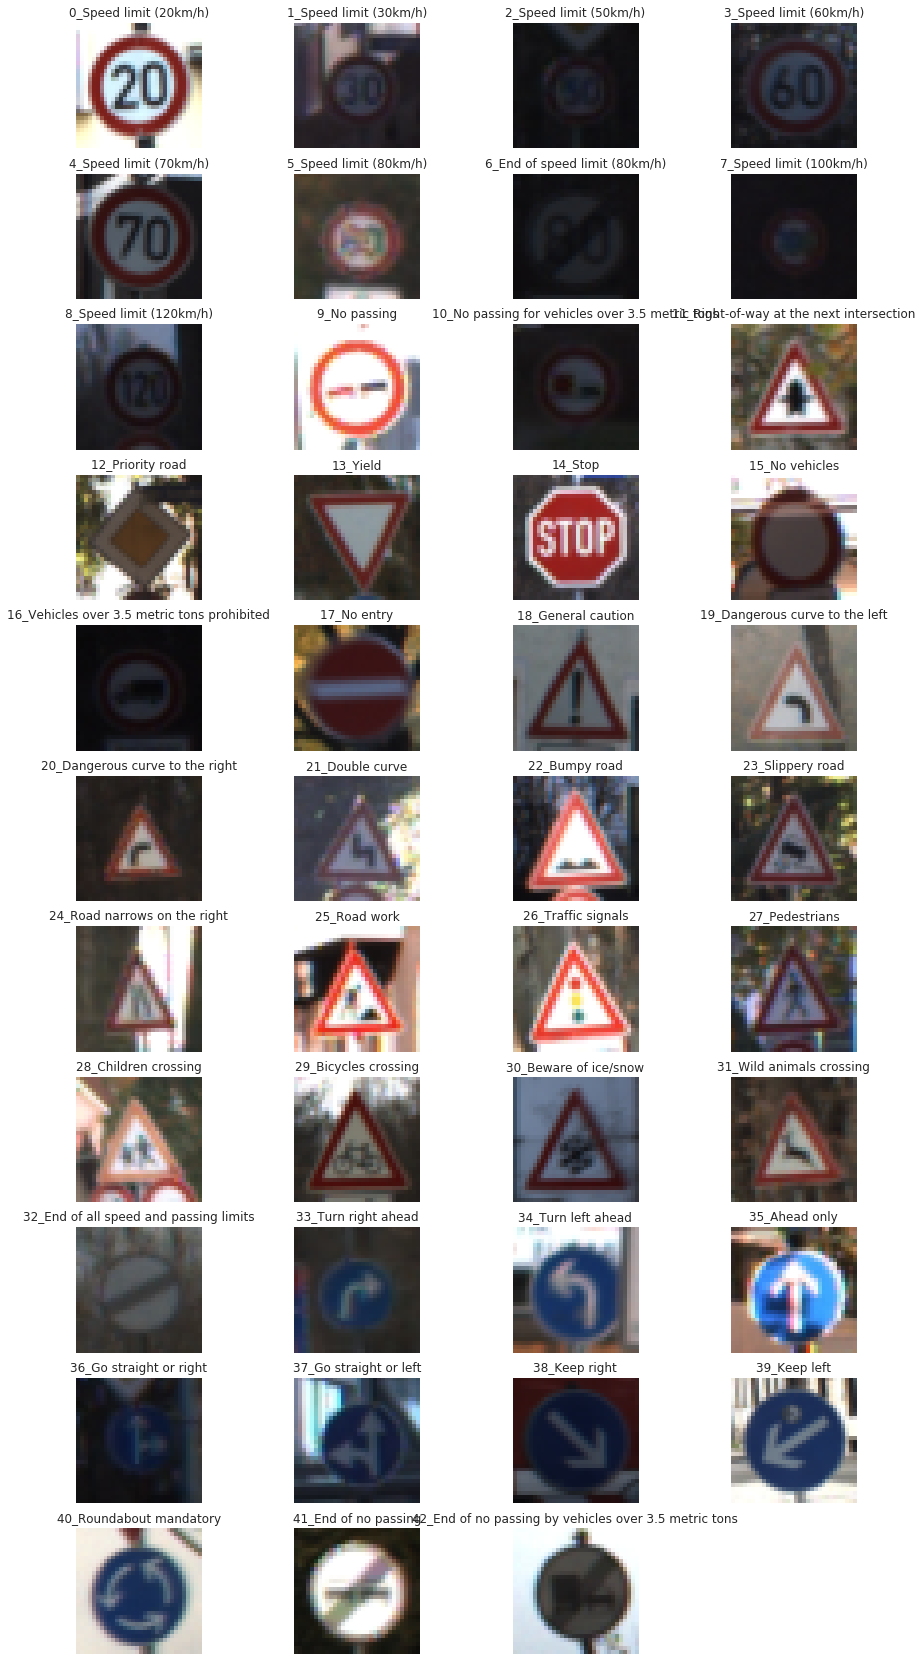

In [5]:
view_dataset_img(X_train,y_train)

### View data distribution

In [6]:
def view_data_distribution(df,cols,title='dataset distribution'):
    sns.set_style("darkgrid")
    ax = df_signlbl[cols] \
    .plot(x="SignName",xticks=df_signlbl.ClassId,figsize=(13,4), marker='o')#,kind='bar')
    ax.set_xticklabels(df_signlbl["SignName"],rotation=90)
    ax.set_ylabel('count')
    ax.set_title(title)

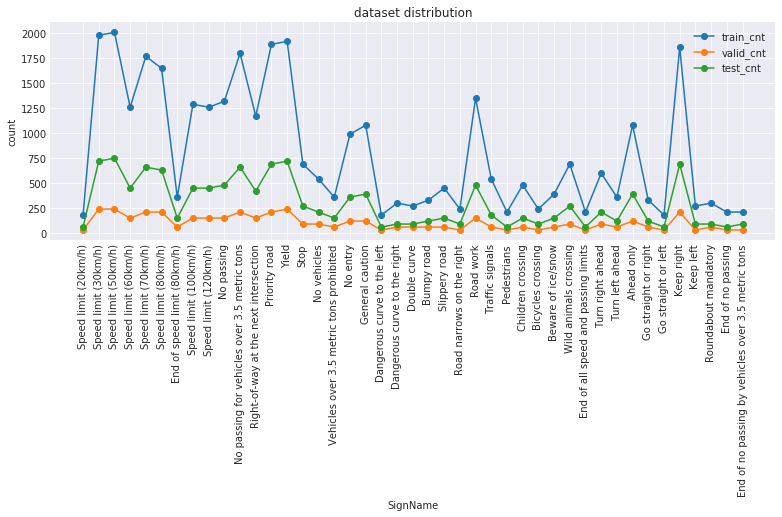

In [7]:
view_data_distribution(df_signlbl,['SignName','train_cnt','valid_cnt', 'test_cnt'])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 3)


### Augment Data

Referred to http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf 

In [9]:
## Merge them all 
X_merge = np.concatenate((X_train,np.concatenate((X_valid,X_test),axis=0)),axis=0)
y_merge = np.concatenate((y_train,np.concatenate((y_valid,y_test),axis=0)),axis=0)

df_signlbl = pd.read_csv("signnames.csv")
df_signlbl['merge_cnt'] = pd.Series(y_merge).value_counts()
df_signlbl.head(3)

,ClassId,SignName,merge_cnt
0,0,Speed limit (20km/h),270
1,1,Speed limit (30km/h),2940
2,2,Speed limit (50km/h),3000


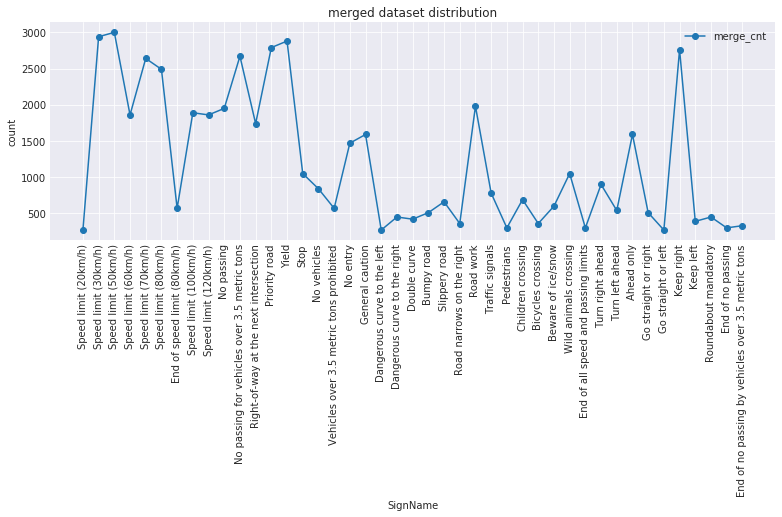

In [10]:
view_data_distribution(df_signlbl,['SignName','merge_cnt'], 'merged dataset distribution')

### Test fake image

In [11]:
def gen_fakeimg(img):
    ## Make image a bit brighter
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    delta = np.random.randint(0,100)
    lim = 255 - delta
    v[v > lim] = 255
    v[v <= lim] += delta
    br_hsv = cv2.merge((h, s, v))
    br_img = cv2.cvtColor(br_hsv, cv2.COLOR_HSV2RGB)
    
    ## first, randomly rotate image a bit 
    r_deg = np.random.uniform(-10,10)
    w,h,c = img.shape
    rot_M = cv2.getRotationMatrix2D((w/2,h/2),r_deg,1)
    r_img = cv2.warpAffine(br_img, rot_M, (w,h))
    
    ## translate 
    tr_x = np.random.uniform(-3,3)
    tr_y = np.random.uniform(-3,3)
    tr_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    tr_img = cv2.warpAffine(r_img, tr_M, (w,h))
    
    ## and sheer
    low = np.random.randint(0, 3)
    high = np.random.randint(w - 3, w)

    points_from = np.float32([[0,0], [w,0], [0,h], [w,h]])
    points_to = np.float32([[0, 0], [high, low], [low, h],[w, high]])
    sh_M = cv2.getPerspectiveTransform(points_from, points_to)
    sh_img = cv2.warpPerspective(tr_img, sh_M, (w,h))
    
    return sh_img

def gen_fakeimg_by_class(srcImg,srcLbl,cls, num) :
    new_imgs=[]
    new_lbls=[]
    for i in range(num) :
        img = srcImg[np.random.choice(np.where(srcLbl == cls)[0])]
        new_imgs.append(gen_fakeimg(img))
        new_lbls.append(cls)
    return new_imgs, new_lbls

def visualize_img_array(img_arr) :
    sns.set_style("dark")    
    fig = plt.figure(figsize=(15,3))
    size= min (10,len(img_arr))
    print ("display max {} elements".format(str(size)))
    for i in range(1,size) :
        ax = plt.subplot(1,size,i)
        ax.set_xticks([]),ax.set_yticks([])
        plt.imshow(img_arr[i])

display max 10 elements


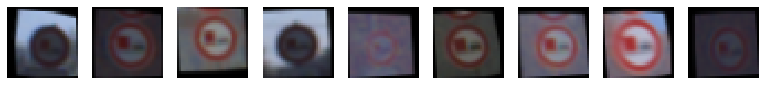

In [12]:
new_imgs, new_lbls = gen_fakeimg_by_class(X_merge,y_merge,10,100)
visualize_img_array(new_imgs)

### Augment dataset by adding faked images 

In [13]:
df_signlbl.head(3)

,ClassId,SignName,merge_cnt
0,0,Speed limit (20km/h),270
1,1,Speed limit (30km/h),2940
2,2,Speed limit (50km/h),3000


In [14]:
def augment_data(X_src, y_src, df_signlbl, colname='merged_cnt', max_cnt=-1) :
    nX = []; nY = [] 
    
    if max_cnt == -1 : 
        max_cnt = df_signlbl[colname].max()
    for idx, row in df_signlbl.iterrows():
        delta = max_cnt - row[colname] 
        n_imgs, n_lbls = gen_fakeimg_by_class(X_src, y_src,idx,delta)
        nX += n_imgs; nY += n_lbls
    
    x_aug = np.concatenate((X_src, np.array(nX)), axis=0)
    y_aug = np.concatenate((y_src, np.array(nY)), axis=0)
    
    return x_aug, y_aug

In [15]:
# augment dataset and recalculate dataset count
X_aug, y_aug = augment_data(X_merge, y_merge, df_signlbl, colname='merge_cnt', max_cnt=-1)
df_signlbl = pd.read_csv("signnames.csv")
df_signlbl['aug_cnt'] = pd.Series(y_aug).value_counts()
df_signlbl['merge_cnt'] = pd.Series(y_merge).value_counts()
df_signlbl.head(3)

,ClassId,SignName,aug_cnt,merge_cnt
0,0,Speed limit (20km/h),3000,270
1,1,Speed limit (30km/h),3000,2940
2,2,Speed limit (50km/h),3000,3000


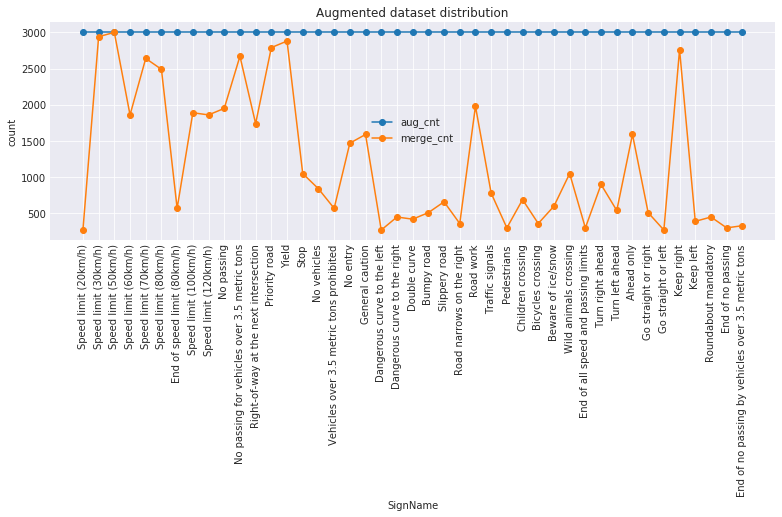

In [16]:
view_data_distribution(df_signlbl,['SignName','aug_cnt','merge_cnt'], 'Augmented dataset distribution')

### Split augmented data into train / valid / test

In [17]:
X_sh, y_sh = shuffle(X_aug, y_aug)

Xa_train, Xa_vt, ya_train, ya_vt = train_test_split(X_sh, y_sh, test_size=0.3)
Xa_test, Xa_valid, ya_test, ya_valid = train_test_split(Xa_vt,ya_vt, test_size=0.4)

df_signlbl = pd.read_csv("signnames.csv")
df_signlbl['train_cnt'] = pd.Series(ya_train).value_counts()
df_signlbl['test_cnt']  = pd.Series(ya_test).value_counts()
df_signlbl['valid_cnt'] = pd.Series(ya_valid).value_counts()
df_signlbl.head(3)

,ClassId,SignName,train_cnt,test_cnt,valid_cnt
0,0,Speed limit (20km/h),2186,486,328
1,1,Speed limit (30km/h),2086,519,395
2,2,Speed limit (50km/h),2103,540,357


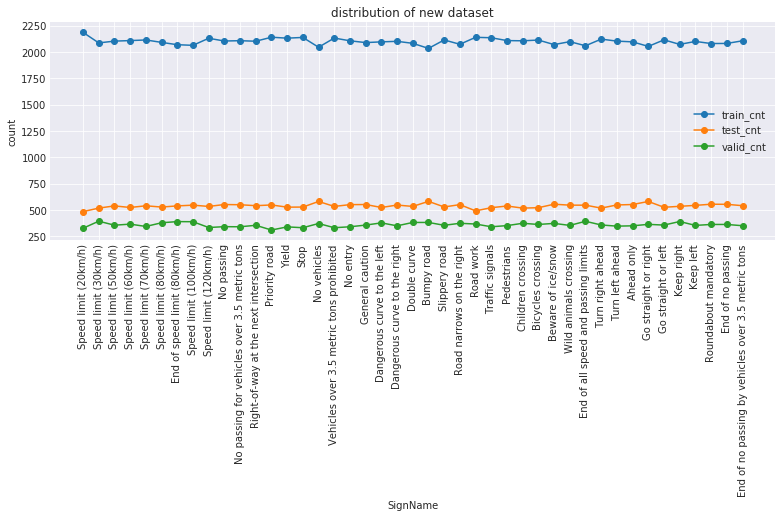

In [18]:
view_data_distribution(df_signlbl,['SignName','train_cnt','test_cnt','valid_cnt'], 'distribution of new dataset')

#### View augmented dataset

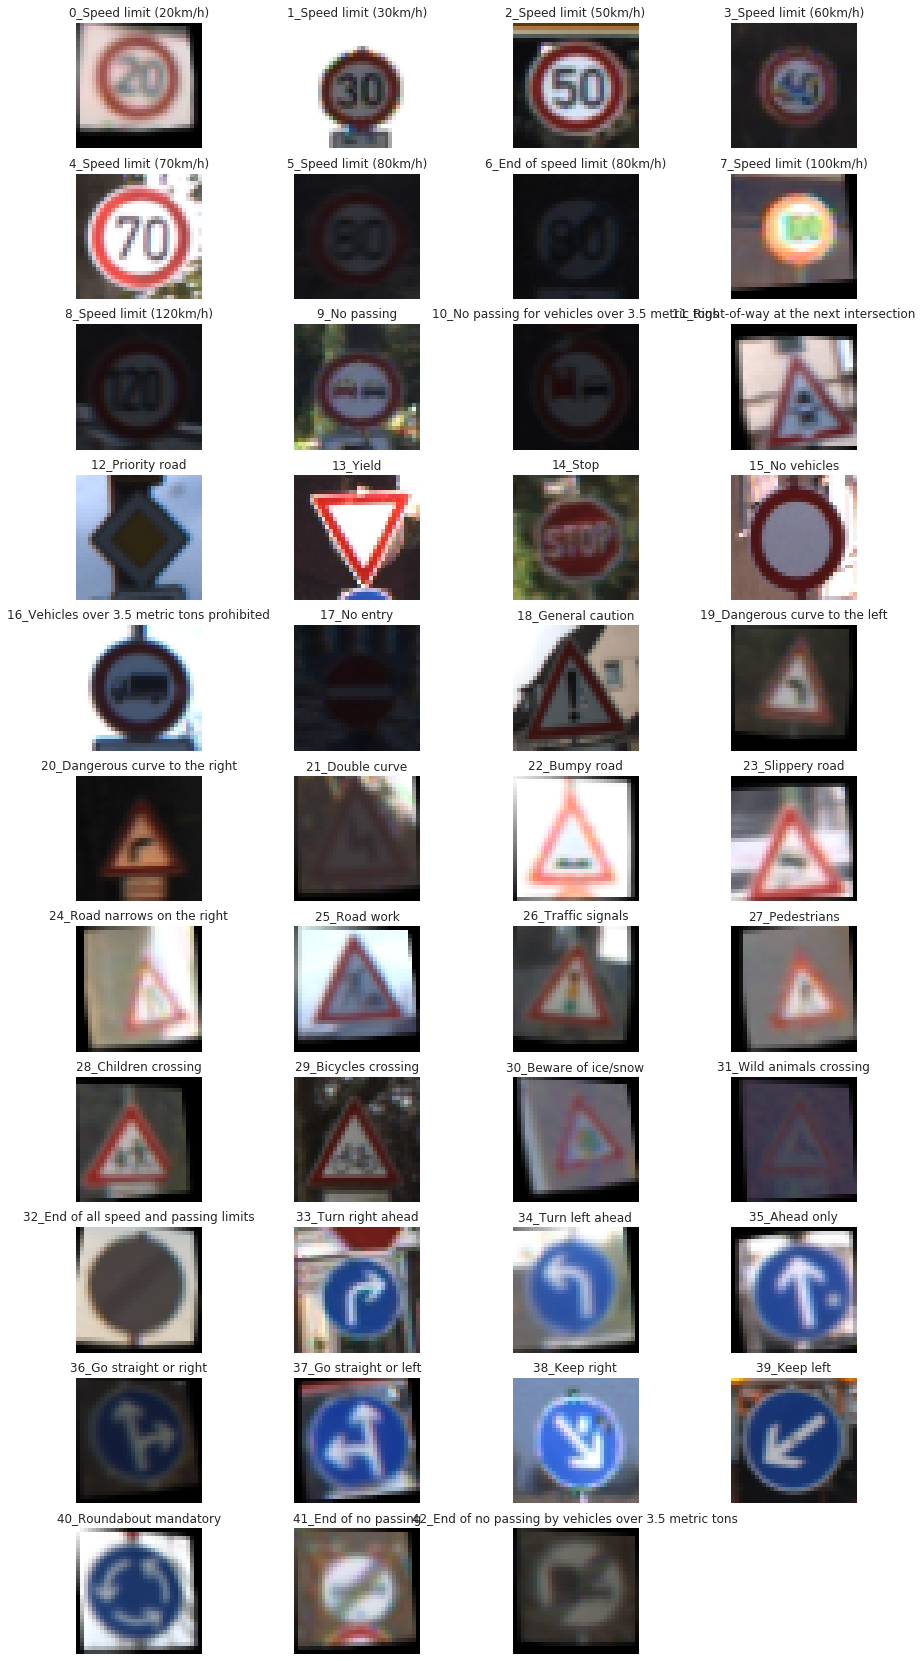

In [19]:
view_dataset_img(Xa_train,ya_train)

### Normalize Image

#### I apply tf.image.per_image_standardization(image), see the model below

```python
 :
norm_x = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), x)
 :
```

## Model Architecture

In [20]:
#from tensorflow.contrib.layers import flatten

def LeNetTrafficSign(x,p_dropout):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Input layer with Normalization
    norm_x = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x)
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6)) 
    conv1   = tf.nn.conv2d(norm_x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120)) 
    #fc1_b = tf.Variable(tf.truncated_normal([120], mu, sigma))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    # Dropout on fullyconnected layer
    fc1    = tf.nn.dropout(fc1, p_dropout)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout on fullyconnected layer
    #fc2    = tf.nn.dropout(fc2, p_dropout)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_class), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.truncated_normal([n_class], mu, sigma))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [21]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3)) # input 
y = tf.placeholder(tf.int32, (None)) 
n_class = len(df_signlbl)
one_hot_y = tf.one_hot(y, n_class)
p_dropout = tf.placeholder(tf.float32)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
rate = 0.001

logits = LeNetTrafficSign(x,p_dropout)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
## First without regularization
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [23]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, batch_size, dropout):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, p_dropout:dropout})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [24]:
def train_model(X_data,y_data,X_valid,y_valid,epochs=25,batchsize=128,dropout=0.8) :
    accuracy = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_data)

        print("Training...")
        print()
        for i in range(epochs):
            X_ep, y_ep = shuffle(X_data, y_data)
            for offset in range(0, num_examples, batchsize):
                end = offset + batchsize
                batch_x, batch_y = X_ep[offset:end], y_ep[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, p_dropout:dropout})

            validation_accuracy = evaluate(X_valid, y_valid, batchsize, dropout)
            #clear_output()
            print("EPOCH {} ...".format(i+1), "Validation Accuracy = {:.3f}".format(validation_accuracy))
            accuracy.append(validation_accuracy)

        saver.save(sess, './lenet')
        print("Model saved")
        df_acc = pd.DataFrame(accuracy, columns=list(['valid_acc']))
        
    return df_acc

---
### Train model and view training accuracy

Training...

EPOCH 1 ... Validation Accuracy = 0.711
EPOCH 2 ... Validation Accuracy = 0.820
EPOCH 3 ... Validation Accuracy = 0.861
EPOCH 4 ... Validation Accuracy = 0.875
EPOCH 5 ... Validation Accuracy = 0.889
EPOCH 6 ... Validation Accuracy = 0.897
EPOCH 7 ... Validation Accuracy = 0.910
EPOCH 8 ... Validation Accuracy = 0.919
EPOCH 9 ... Validation Accuracy = 0.917
EPOCH 10 ... Validation Accuracy = 0.920
EPOCH 11 ... Validation Accuracy = 0.925
EPOCH 12 ... Validation Accuracy = 0.925
EPOCH 13 ... Validation Accuracy = 0.932
EPOCH 14 ... Validation Accuracy = 0.933
EPOCH 15 ... Validation Accuracy = 0.932
EPOCH 16 ... Validation Accuracy = 0.935
EPOCH 17 ... Validation Accuracy = 0.936
EPOCH 18 ... Validation Accuracy = 0.936
EPOCH 19 ... Validation Accuracy = 0.940
EPOCH 20 ... Validation Accuracy = 0.937
EPOCH 21 ... Validation Accuracy = 0.937
EPOCH 22 ... Validation Accuracy = 0.943
EPOCH 23 ... Validation Accuracy = 0.944
EPOCH 24 ... Validation Accuracy = 0.942
EPOCH 25 ...

Text(4.6,0.925,'0.93')

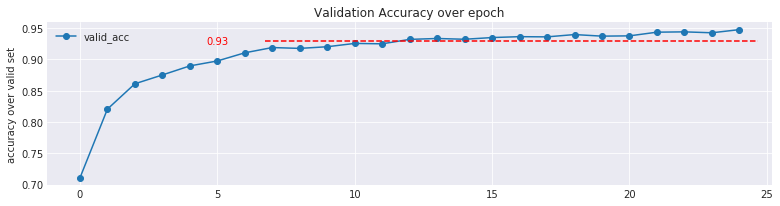

In [25]:
df_acc = train_model(Xa_train,ya_train,Xa_valid,ya_valid,epochs=25,batchsize=128,dropout=0.6)
sns.set_style("darkgrid")
ax = df_acc.plot(figsize=(13,3), marker='o', title='Validation Accuracy over epoch')
ax.set_ylabel('accuracy over valid set')
ax.axhline(y=.93, xmin=0.3, xmax=0.98, linestyle='--', color='red')
ax.text(4.6,0.925,"0.93",color='red')

---
### Check prediction performance


In [26]:
def load_image(path,w=None,h=None) :
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_RGB2BGR)
    if w and h :
        img = cv2.resize(img,(w,h), interpolation = cv2.INTER_CUBIC)
    return img

def show_image(img,dw=5) :
    """
    Display image of given path
    resize image when w and h are set
    """
    h, w = img.shape[:2]
    # Make w as 10 
    # 10 = w : v : h 
    vr = dw * h / w 
    sns.set_style('dark')
    plt.figure(figsize=(dw,vr))
    plt.imshow(img,interpolation='nearest', aspect='auto'),plt.show()

def view_img_lbl(X_img,y_lbls) :
    # View all representative signs
    cols = 4 ; rows = 11  
    sns.set_style("dark")
    fig = plt.figure(figsize=(15,30))
    for i in range(0,len(y_lbls)) :
        signName = y_lbls[i]
        img=X_img[i]
        ax = plt.subplot(rows, cols, i+1, title=signName)
        ax.set_xticks([]),ax.set_yticks([])
        plt.imshow(img)    
    
def run_predictions(q_imgs):
    pred = tf.argmax(logits, 1)
    dropout = 0.6
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        image_data = tf.gfile.FastGFile('./query_imgs/speed_30.png', 'rb').read()
        softmax_tensor = sess.graph.get_tensor_by_name('SoftmaxCrossEntropyWithLogits:0')
        prediction = sess.run(pred, feed_dict={x: q_imgs,p_dropout:dropout})
        return prediction
    
def get_prediction_labels(predictions, df_signlbl):
    prediction_labels=[ df_signlbl.at[pred,"SignName"] for pred in predictions ] 
    return prediction_labels

Sample images from the test data set and view prediction result 

INFO:tensorflow:Restoring parameters from ./lenet


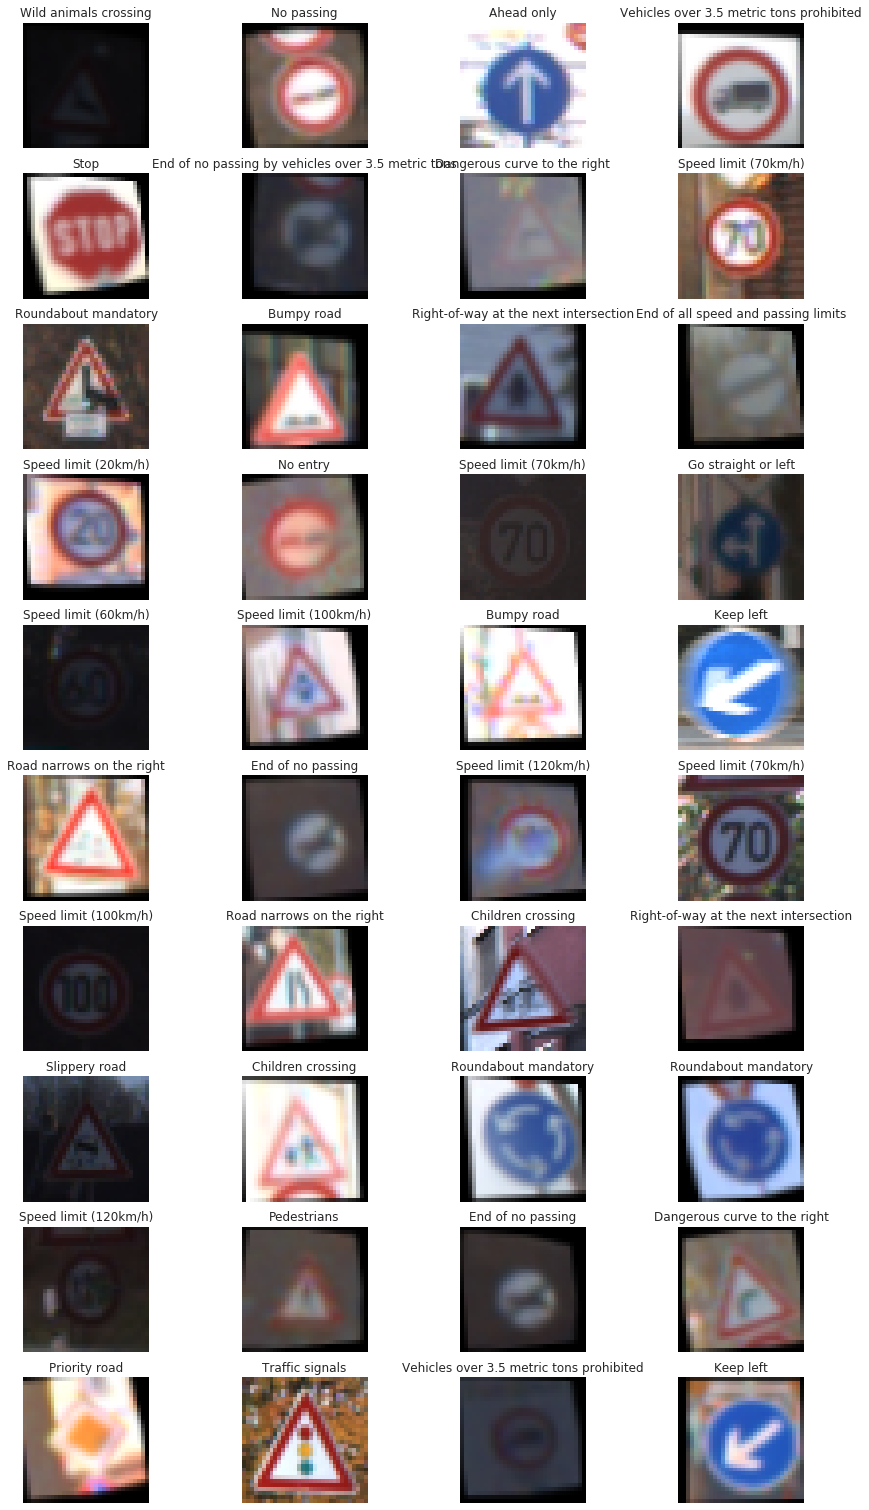

In [27]:
X_sample, y_sample = shuffle(Xa_test, ya_test)
n_sample = 40 
q_images = X_sample[:n_sample]
q_pred_lbls = get_prediction_labels(run_predictions(q_images),df_signlbl)
view_img_lbl(q_images,q_pred_lbls)

---
### View confusion matrix

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(15,12),
                          disp_value=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    sns.set_style('dark')
    fig = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if disp_value :
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Correct Category')
    plt.xlabel('Classified Category')


generate prediction list ya_test_pred

In [29]:
ya_test_pred = run_predictions(Xa_test)
cnf_matrix = confusion_matrix(ya_test, ya_test_pred)
np.set_printoptions(precision=2)
cnf_matrix

INFO:tensorflow:Restoring parameters from ./lenet


array([[466,   2,   0, ...,   0,   0,   0],
       [ 10, 493,   4, ...,   2,   0,   0],
       [  0,   7, 522, ...,   2,   0,   0],
       ..., 
       [  0,   0,   1, ..., 545,   0,   0],
       [  0,   0,   0, ...,   3, 535,   7],
       [  0,   0,   0, ...,   0,   5, 523]])

Normalized confusion matrix


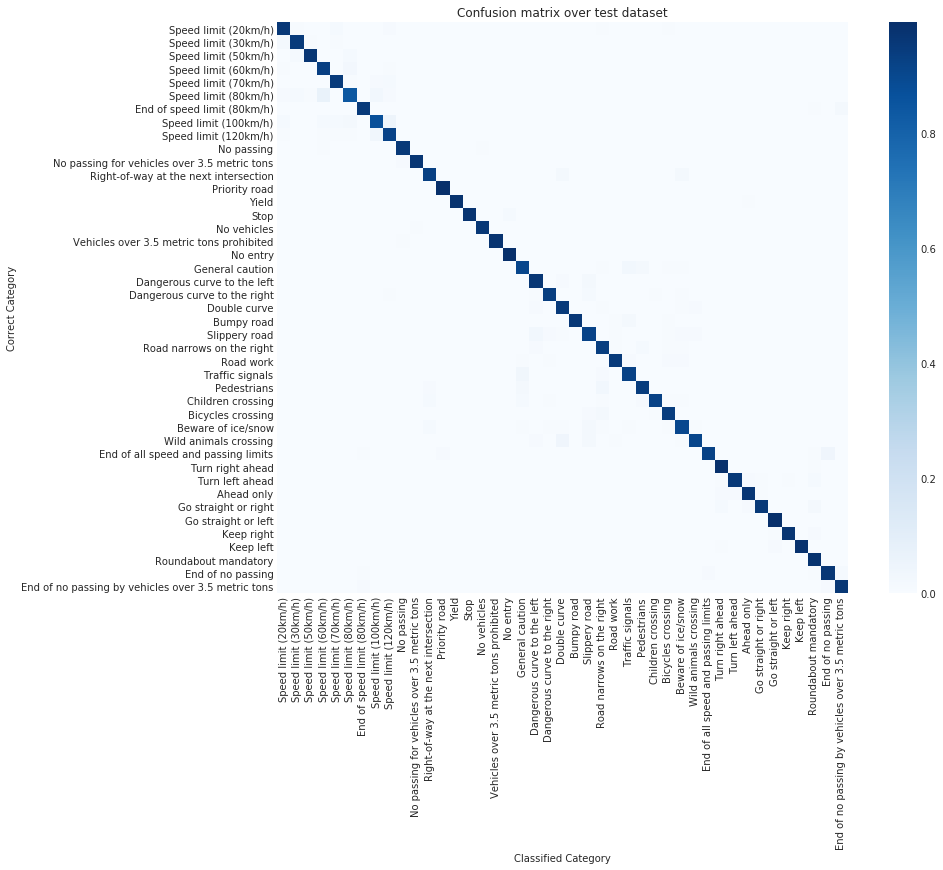

In [30]:
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=df_signlbl['SignName'].values, normalize=True,
                      title='Confusion matrix over test dataset',figsize=(15,12),disp_value=False)

plt.show()

Normalized confusion matrix


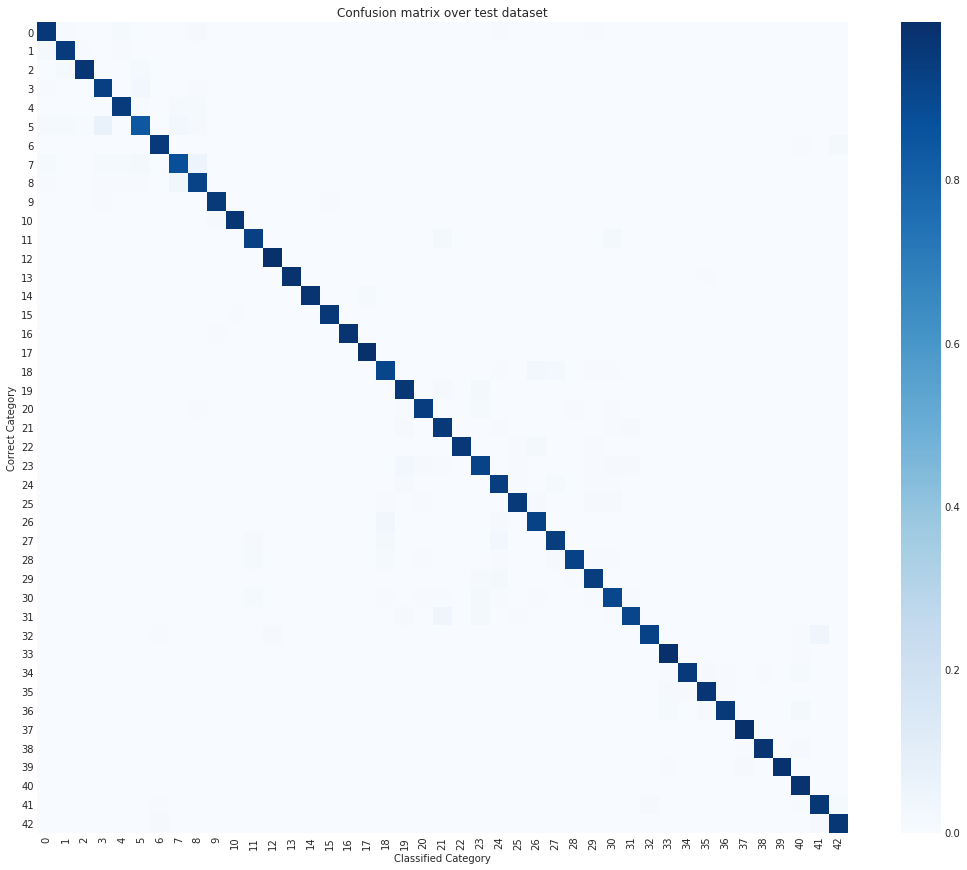

In [31]:
plot_confusion_matrix(cnf_matrix, classes=df_signlbl['ClassId'].values, normalize=True,
                      title='Confusion matrix over test dataset',figsize=(15,12),disp_value=False)

plt.show()

--- 
Confusion matrix over whole Augment dataset 

In [32]:
y_aug_pred = run_predictions(X_aug)
cnf_matrix = confusion_matrix(y_aug, y_aug_pred)
cnf_matrix

INFO:tensorflow:Restoring parameters from ./lenet


array([[2928,   10,    0, ...,    1,    0,    0],
       [  33, 2866,   20, ...,    5,    0,    1],
       [   2,   35, 2898, ...,    5,    0,    0],
       ..., 
       [  23,    5,    1, ...,  458,    6,   28],
       [  28,    2,    3, ...,   12,  301,   16],
       [  15,    0,    1, ...,    5,    1,  333]])

Normalized confusion matrix


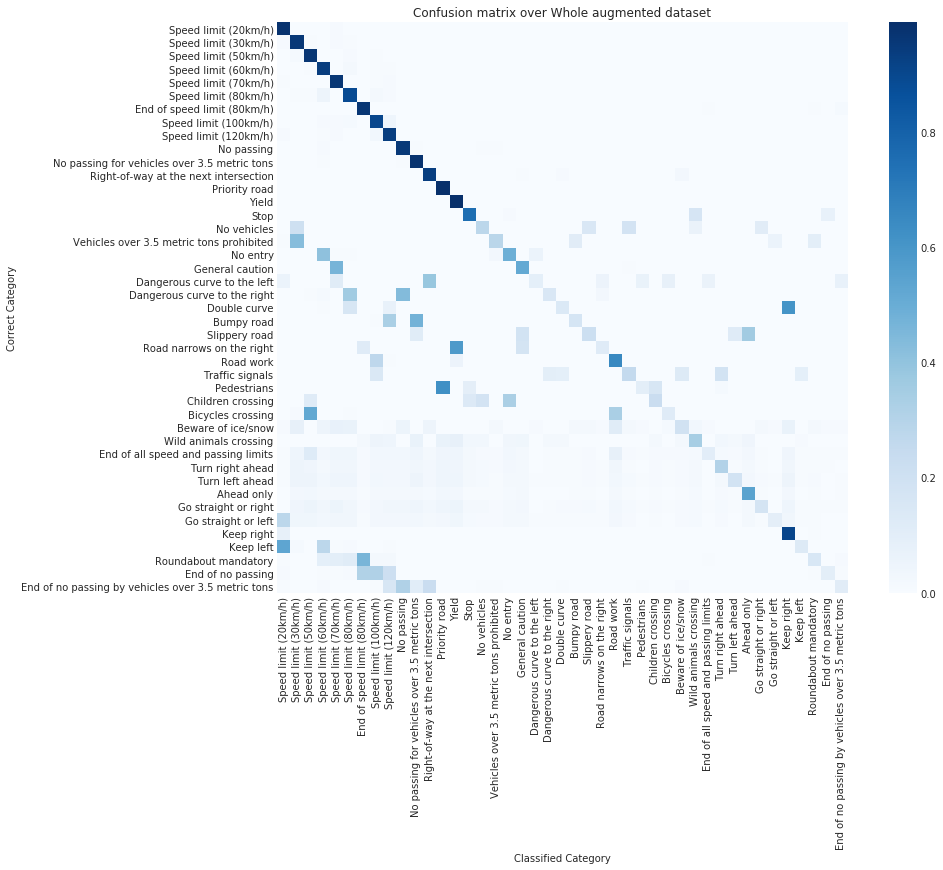

In [33]:
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=df_signlbl['SignName'].values, normalize=True,
                      title='Confusion matrix over Whole augmented dataset',figsize=(15,12),disp_value=False)
plt.show()

---
Confusion matrix over whole merged dataset ( original X_train, X_valid, X_test ) 

In [34]:
y_merge_pred = run_predictions(X_merge)
cnf_matrix = confusion_matrix(y_merge, y_merge_pred)
cnf_matrix

INFO:tensorflow:Restoring parameters from ./lenet


array([[ 264,    3,    0, ...,    0,    0,    0],
       [  25, 2840,   24, ...,    0,    0,    2],
       [   1,   44, 2889, ...,    1,    0,    1],
       ..., 
       [   0,    1,    0, ...,  447,    0,    0],
       [   0,    0,    0, ...,    0,  299,    0],
       [   0,    0,    0, ...,    0,    0,  328]])

Normalized confusion matrix


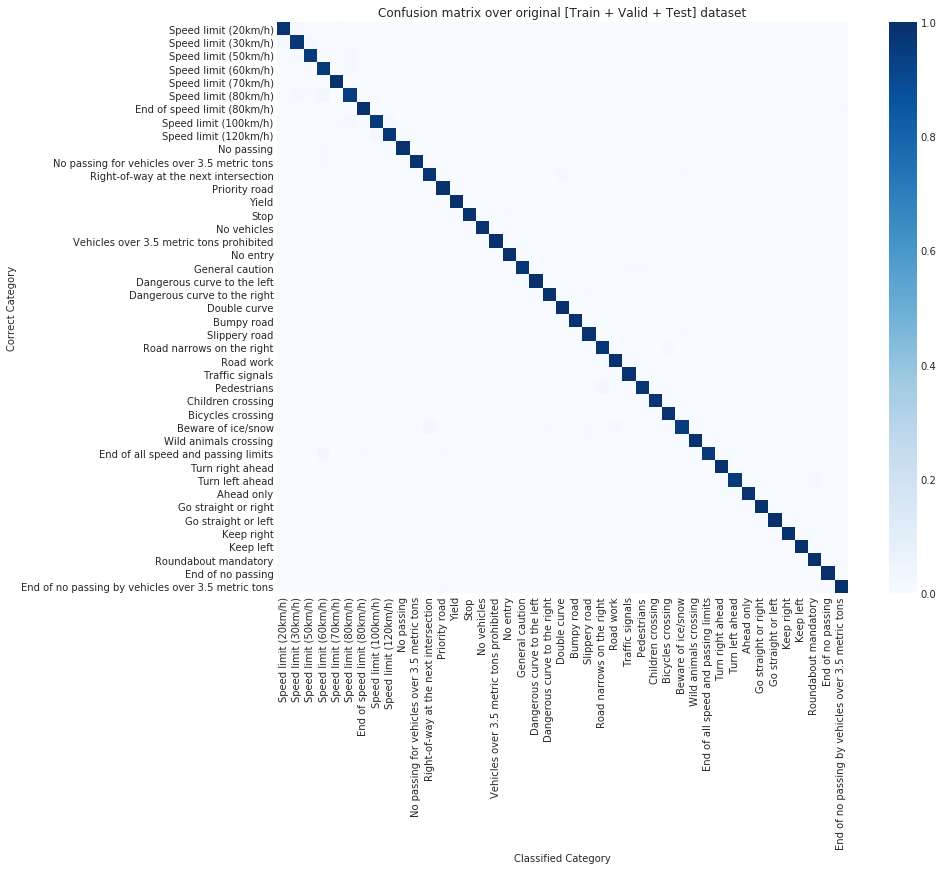

In [35]:
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=df_signlbl['SignName'].values, normalize=True,
                      title='Confusion matrix over original [Train + Valid + Test] dataset',figsize=(15,12),disp_value=False)
plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

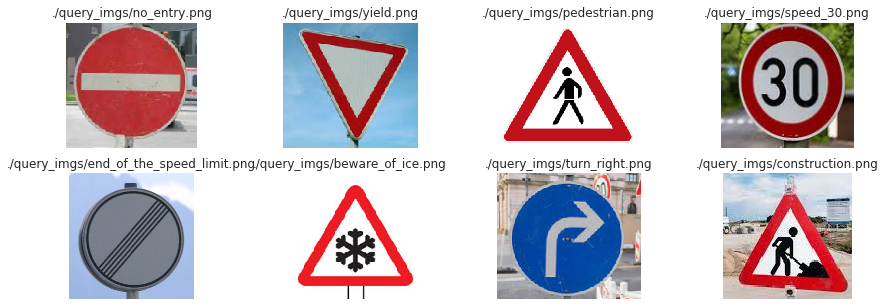

In [36]:
image_paths = glob.glob('./query_imgs/*')
q_images = [ load_image(img_path) for img_path in image_paths ] 
q_images_32_32 = [ load_image(img_path,w=32,h=32) for img_path in image_paths ] 
view_img_lbl(q_images,image_paths)

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./lenet


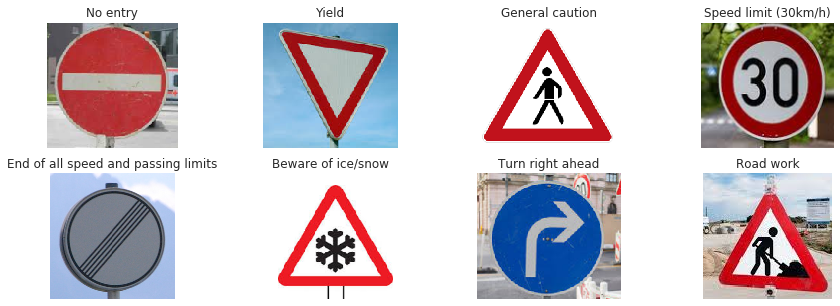

In [37]:
q_pred = run_predictions(q_images_32_32)
q_pred_lbls = get_prediction_labels(q_pred,df_signlbl)
view_img_lbl(q_images,q_pred_lbls)

### Analyze Performance

In [38]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
q_truth=[17, 13, 27,  1,  6, 30, 33, 25]
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(q_images_32_32, q_truth, len(q_truth), 0.6)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.875


---
### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [39]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
def view_img_top5lbl(X_img,y_toplbls,df_signlbl) :
    # View all representative signs
    sns.set_style("dark")
    for i in range(len(y_toplbls.values)) :
        fig = plt.figure(figsize=(2,2))
        img=X_img[i]
        plt.imshow(img)
        plt.show()
        for r, (clas, prob) in enumerate(zip(y_toplbls.indices[i],y_toplbls.values[i])):
            print("Ranking {} : Class {} / Prob {:.3f} : SignName {} ".format(r, clas, prob, df_signlbl.at[clas,"SignName"]))


INFO:tensorflow:Restoring parameters from ./lenet


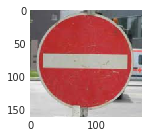

Ranking 0 : Class 17 / Prob 1.000 : SignName No entry 
Ranking 1 : Class 14 / Prob 0.000 : SignName Stop 
Ranking 2 : Class 20 / Prob 0.000 : SignName Dangerous curve to the right 
Ranking 3 : Class 9 / Prob 0.000 : SignName No passing 
Ranking 4 : Class 3 / Prob 0.000 : SignName Speed limit (60km/h) 


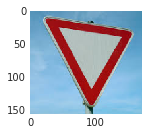

Ranking 0 : Class 13 / Prob 1.000 : SignName Yield 
Ranking 1 : Class 9 / Prob 0.000 : SignName No passing 
Ranking 2 : Class 8 / Prob 0.000 : SignName Speed limit (120km/h) 
Ranking 3 : Class 1 / Prob 0.000 : SignName Speed limit (30km/h) 
Ranking 4 : Class 14 / Prob 0.000 : SignName Stop 


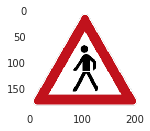

Ranking 0 : Class 27 / Prob 0.908 : SignName Pedestrians 
Ranking 1 : Class 11 / Prob 0.054 : SignName Right-of-way at the next intersection 
Ranking 2 : Class 18 / Prob 0.038 : SignName General caution 
Ranking 3 : Class 24 / Prob 0.000 : SignName Road narrows on the right 
Ranking 4 : Class 26 / Prob 0.000 : SignName Traffic signals 


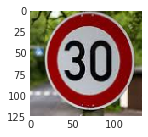

Ranking 0 : Class 1 / Prob 1.000 : SignName Speed limit (30km/h) 
Ranking 1 : Class 2 / Prob 0.000 : SignName Speed limit (50km/h) 
Ranking 2 : Class 5 / Prob 0.000 : SignName Speed limit (80km/h) 
Ranking 3 : Class 18 / Prob 0.000 : SignName General caution 
Ranking 4 : Class 0 / Prob 0.000 : SignName Speed limit (20km/h) 


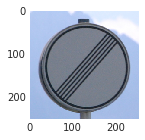

Ranking 0 : Class 32 / Prob 1.000 : SignName End of all speed and passing limits 
Ranking 1 : Class 6 / Prob 0.000 : SignName End of speed limit (80km/h) 
Ranking 2 : Class 36 / Prob 0.000 : SignName Go straight or right 
Ranking 3 : Class 41 / Prob 0.000 : SignName End of no passing 
Ranking 4 : Class 39 / Prob 0.000 : SignName Keep left 


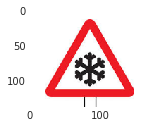

Ranking 0 : Class 30 / Prob 0.975 : SignName Beware of ice/snow 
Ranking 1 : Class 11 / Prob 0.013 : SignName Right-of-way at the next intersection 
Ranking 2 : Class 28 / Prob 0.009 : SignName Children crossing 
Ranking 3 : Class 20 / Prob 0.002 : SignName Dangerous curve to the right 
Ranking 4 : Class 23 / Prob 0.002 : SignName Slippery road 


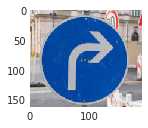

Ranking 0 : Class 33 / Prob 1.000 : SignName Turn right ahead 
Ranking 1 : Class 35 / Prob 0.000 : SignName Ahead only 
Ranking 2 : Class 39 / Prob 0.000 : SignName Keep left 
Ranking 3 : Class 40 / Prob 0.000 : SignName Roundabout mandatory 
Ranking 4 : Class 6 / Prob 0.000 : SignName End of speed limit (80km/h) 


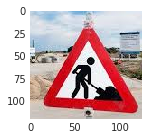

Ranking 0 : Class 25 / Prob 1.000 : SignName Road work 
Ranking 1 : Class 18 / Prob 0.000 : SignName General caution 
Ranking 2 : Class 27 / Prob 0.000 : SignName Pedestrians 
Ranking 3 : Class 28 / Prob 0.000 : SignName Children crossing 
Ranking 4 : Class 36 / Prob 0.000 : SignName Go straight or right 


In [42]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5),feed_dict={x: q_images_32_32, p_dropout:0.6})
    view_img_top5lbl(q_images,top5,df_signlbl)

---
### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [43]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_node_name, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    # ex tf_node_name = 'Conv2D:0' 
    tf_activation = sess.graph.get_tensor_by_name(tf_node_name)
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, p_dropout:0.6})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()

---
Check tensorflow graph node structure with node names

In [44]:
df_nodes = pd.DataFrame([tensor.name for tensor in tf.get_default_graph().as_graph_def().node])
df_nodes.head(10)

,0
0,Placeholder
1,Placeholder_1
2,one_hot/on_value
3,one_hot/off_value
4,one_hot/depth
5,one_hot
6,Placeholder_2
7,map/Shape
8,map/strided_slice/stack
9,map/strided_slice/stack_1


INFO:tensorflow:Restoring parameters from ./lenet


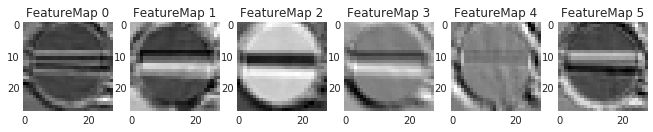

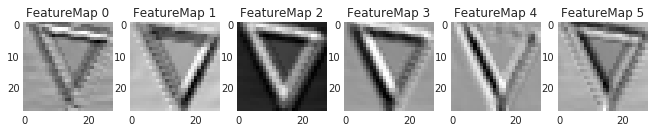

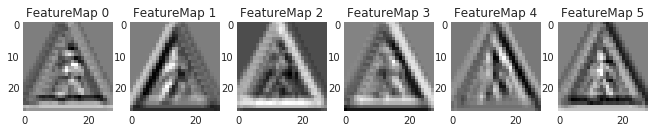

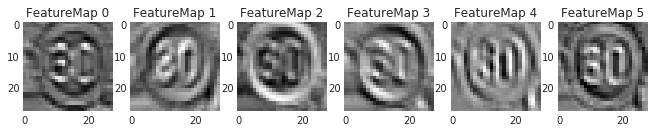

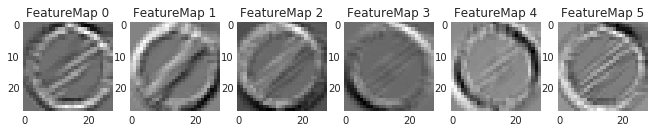

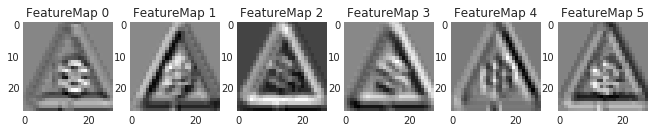

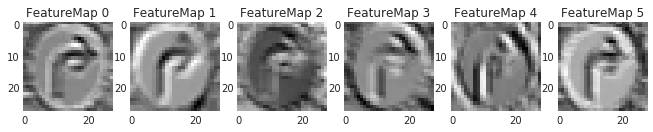

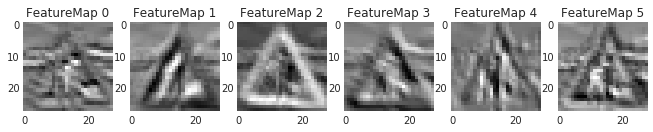

In [46]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for img in q_images_32_32 :
        outputFeatureMap([img], 'Conv2D:0')

INFO:tensorflow:Restoring parameters from ./lenet


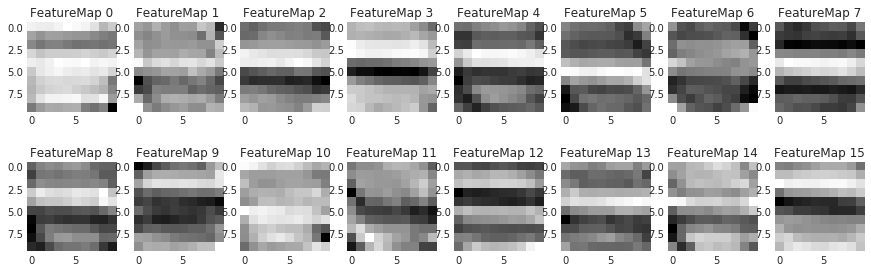

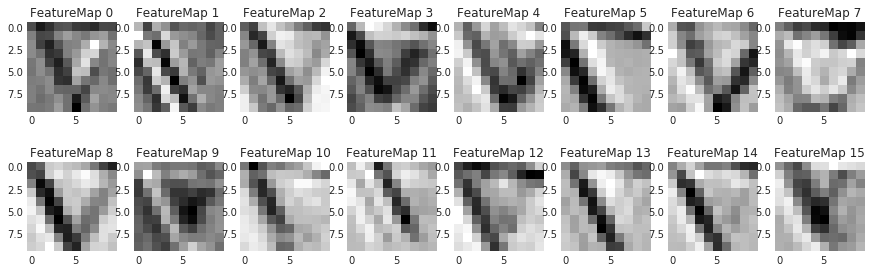

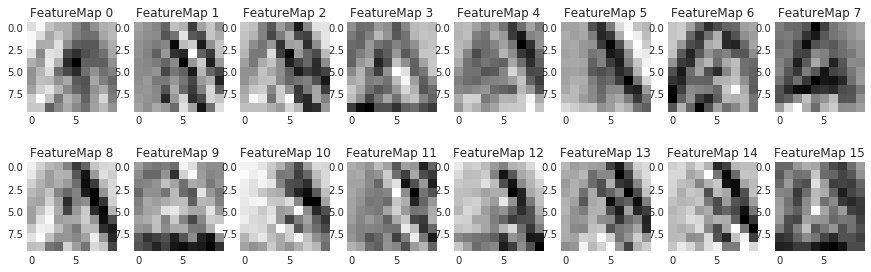

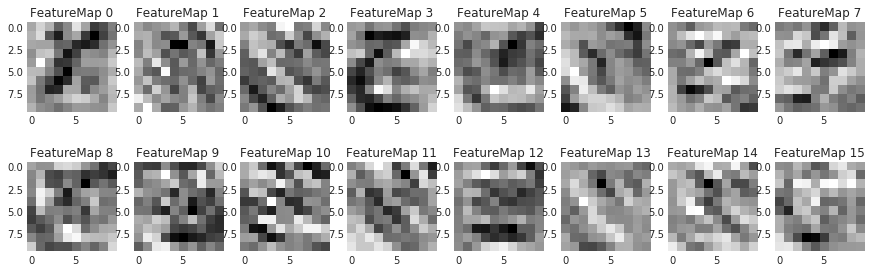

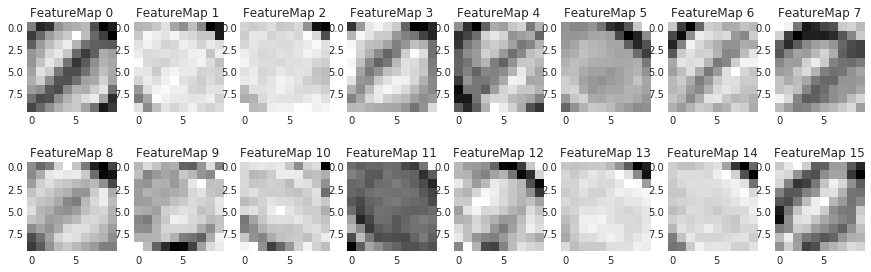

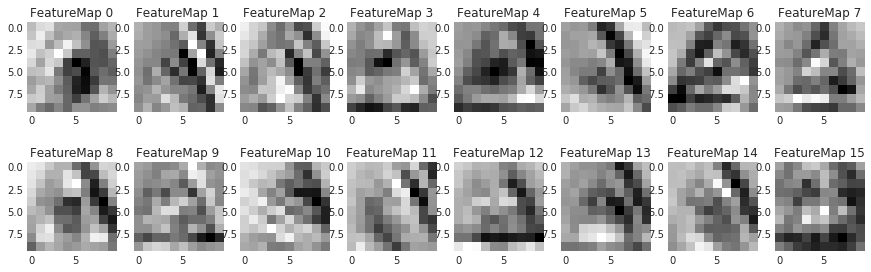

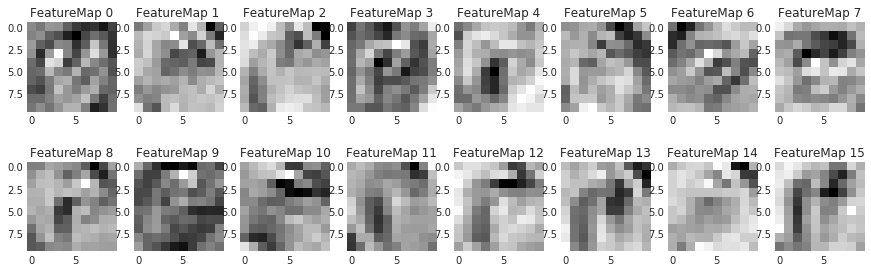

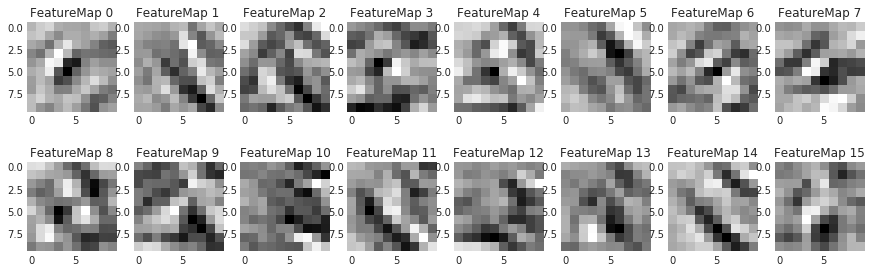

In [47]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for img in q_images_32_32 :
        outputFeatureMap([img], 'Conv2D_1:0')

INFO:tensorflow:Restoring parameters from ./lenet


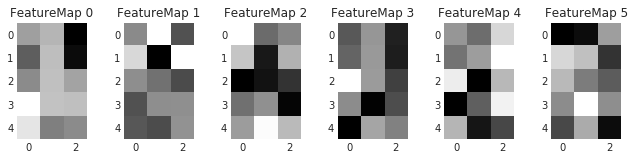

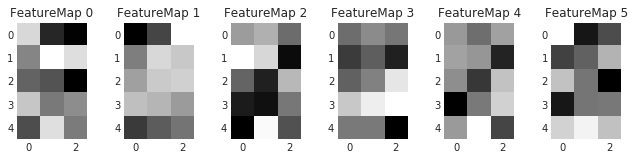

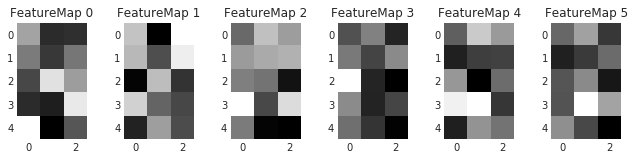

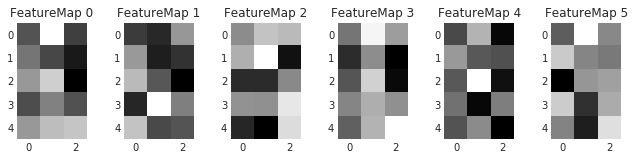

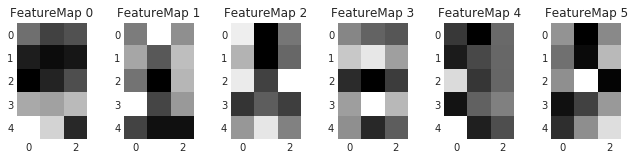

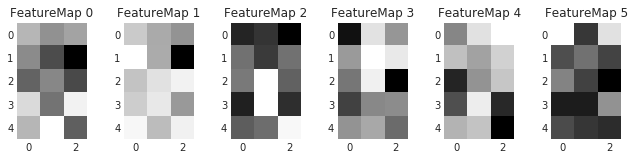

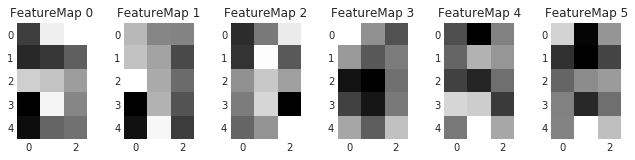

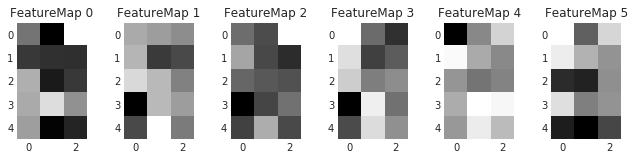

In [48]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for img in q_images_32_32 :
        outputFeatureMap([img], 'truncated_normal:0')

INFO:tensorflow:Restoring parameters from ./lenet


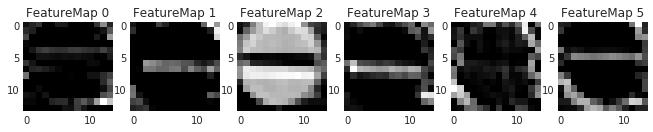

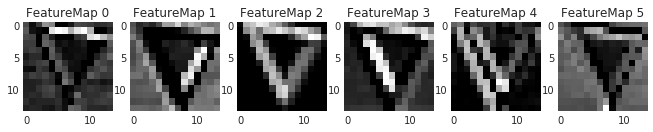

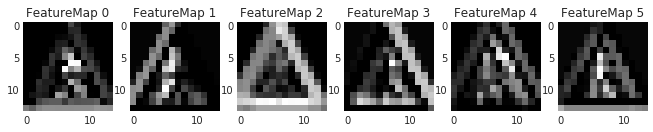

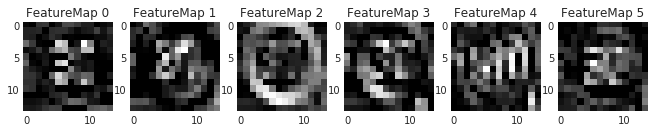

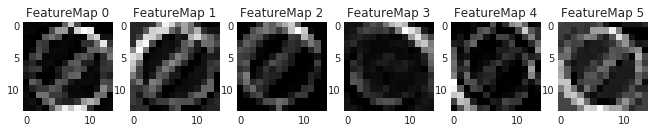

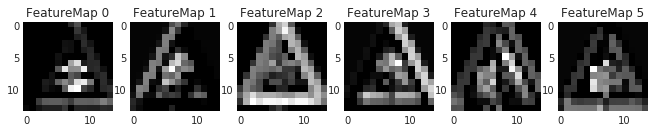

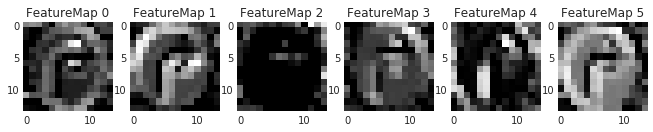

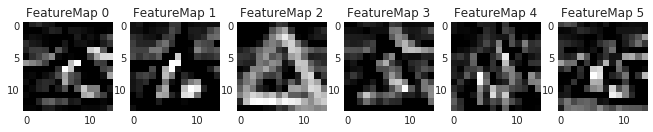

In [49]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for img in q_images_32_32 :
        outputFeatureMap([img], 'MaxPool:0')

INFO:tensorflow:Restoring parameters from ./lenet


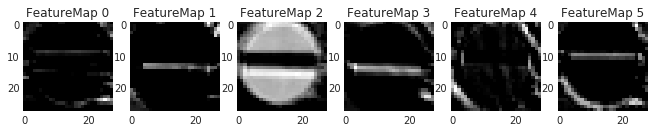

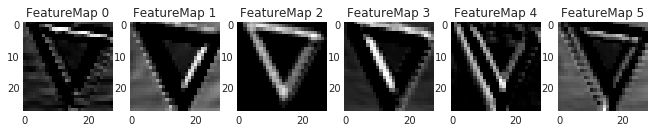

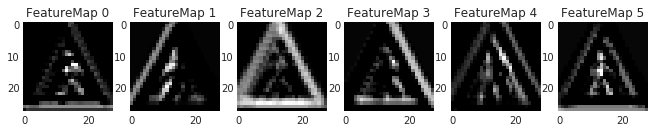

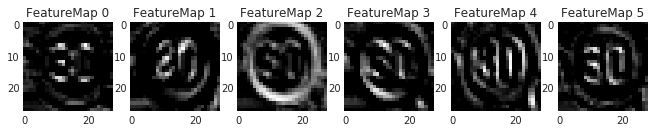

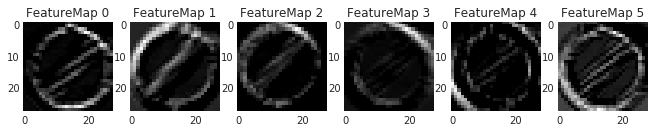

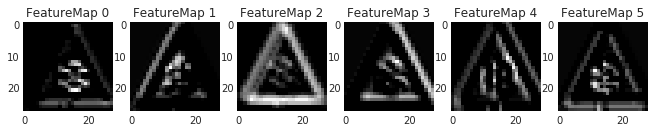

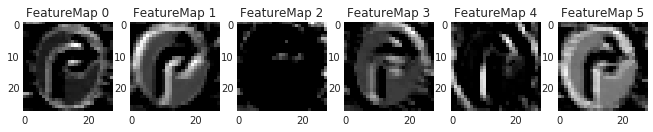

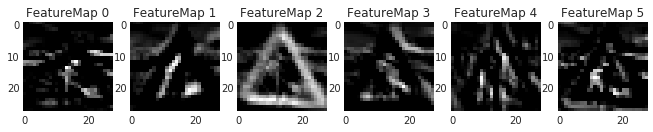

In [50]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for img in q_images_32_32 :
        outputFeatureMap([img], 'Relu:0')

INFO:tensorflow:Restoring parameters from ./lenet


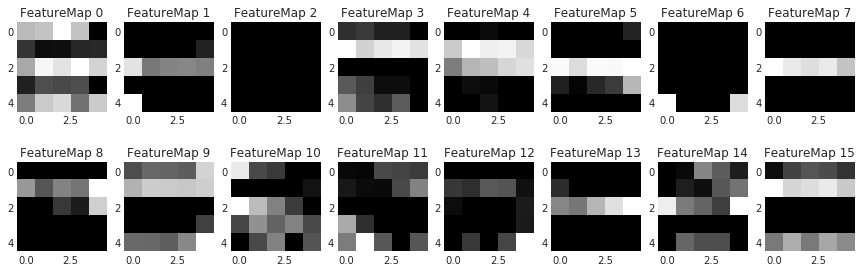

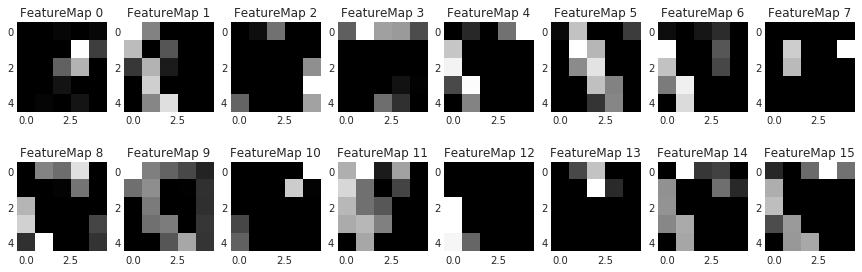

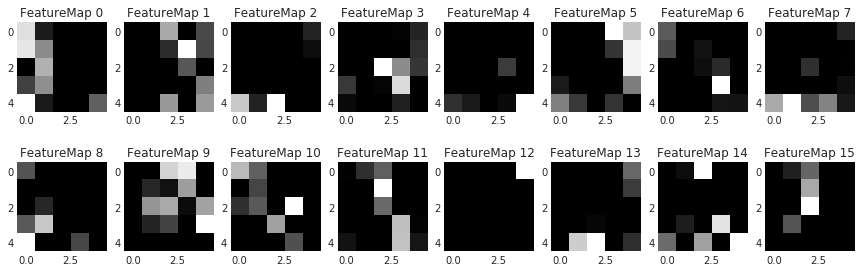

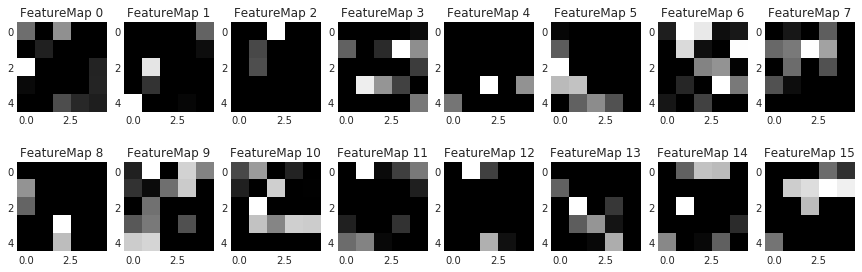

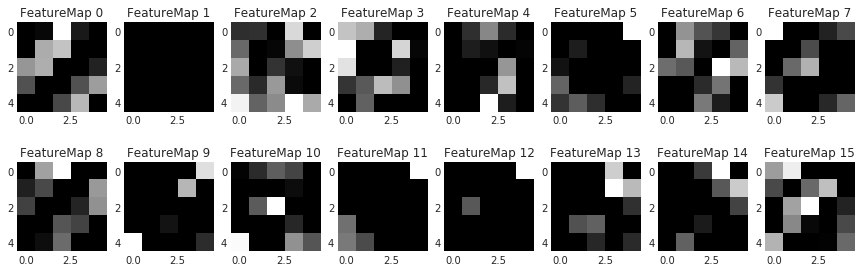

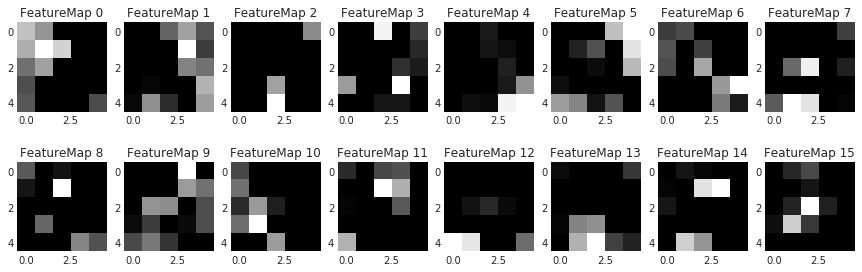

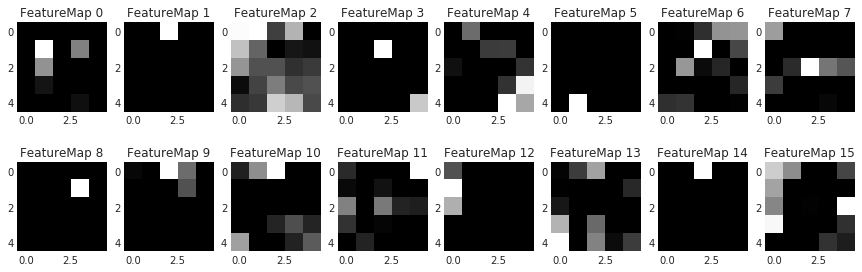

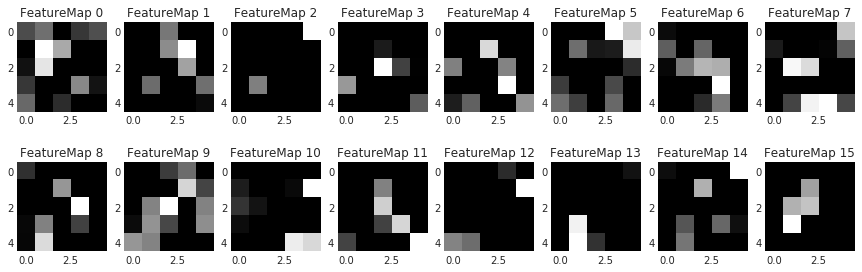

In [51]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for img in q_images_32_32 :
        outputFeatureMap([img], 'MaxPool_1:0')

One can continue with following tf names 

In [52]:
[tensor.name for tensor in tf.get_default_graph().as_graph_def().node]

['Placeholder',
 'Placeholder_1',
 'one_hot/on_value',
 'one_hot/off_value',
 'one_hot/depth',
 'one_hot',
 'Placeholder_2',
 'map/Shape',
 'map/strided_slice/stack',
 'map/strided_slice/stack_1',
 'map/strided_slice/stack_2',
 'map/strided_slice',
 'map/TensorArray',
 'map/TensorArrayUnstack/Shape',
 'map/TensorArrayUnstack/strided_slice/stack',
 'map/TensorArrayUnstack/strided_slice/stack_1',
 'map/TensorArrayUnstack/strided_slice/stack_2',
 'map/TensorArrayUnstack/strided_slice',
 'map/TensorArrayUnstack/range/start',
 'map/TensorArrayUnstack/range/delta',
 'map/TensorArrayUnstack/range',
 'map/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3',
 'map/Const',
 'map/TensorArray_1',
 'map/while/Enter',
 'map/while/Enter_1',
 'map/while/Merge',
 'map/while/Merge_1',
 'map/while/Less/Enter',
 'map/while/Less',
 'map/while/LoopCond',
 'map/while/Switch',
 'map/while/Switch_1',
 'map/while/Identity',
 'map/while/Identity_1',
 'map/while/TensorArrayReadV3/Enter',
 'map/while/Tenso